In [1]:
import pickle
import numpy as np
from tqdm import tqdm
from functools import partial
import pandas as pd

In [2]:
max_n = 2
total_data = [[], [], [], [], []]
for i in range(1, max_n + 1):
    file_name = 'data_256_cat%s.pkl' %i
    loaded_data = pickle.load(open(file_name, 'rb'))

    _image_data, _sentence_data, _sentence_tags, _hashtag_data, _metadata = loaded_data[1]

    _sentence_tags = np.array(_sentence_tags)
    _hashtag_data = np.array(_hashtag_data)
    
    total_data[0].append(_image_data)
    total_data[1].append(_sentence_data)
    total_data[2].append(_sentence_tags)
    total_data[3].append(_hashtag_data)
    total_data[4].append(_metadata)

In [21]:
_image_data = np.concatenate(total_data[0])
_sentence_data = np.concatenate(total_data[1])
_sentence_tags = np.concatenate(total_data[2])
_hashtag_data = np.concatenate(total_data[3])
_metadata = pd.concat(total_data[4])

In [22]:
np.random.seed(1234)
n_valid = 700
n_train = _image_data.shape[0] - n_valid
n_total = n_train + n_valid
indices = np.random.choice(np.arange(_image_data.shape[0]), n_total, replace=False)
train_idx = indices[:n_train]
valid_idx = indices[n_train:]

In [23]:
image_data = _image_data[train_idx]
sentence_data = _sentence_data[train_idx]
sentence_tags = _sentence_tags[train_idx]
hashtag_data = _hashtag_data[train_idx]
metadata = _metadata.iloc[train_idx]

In [24]:
image_valid = _image_data[valid_idx]
sentence_valid = _sentence_data[valid_idx]
sentence_valid = _sentence_tags[valid_idx]
hashtag_valid = _hashtag_data[valid_idx]
metadata_valid = _metadata.iloc[valid_idx]

In [25]:
print(image_data.shape)
print(sentence_data.shape)
print(sentence_tags.shape)
print(hashtag_data.shape)
print(metadata.shape)

(27300, 256, 256, 3)
(27300,)
(27300,)
(27300,)
(27300, 15)


In [26]:
y_train = metadata['category1']
l_label = y_train.unique()
y_train = np.array(y_train)
d_label = {l:i for i, l in enumerate(l_label)}
y_onehot = np.eye(len(d_label))[[d_label[l] for l in y_train]]
n_label = len(d_label)

y_valid = np.array(metadata_valid['category1'])
y_valid_onehot = np.eye(len(d_label))[[d_label[l] for l in y_valid]]

In [38]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [45]:
tf.reset_default_graph()

learning_rate1 = 0.001
learning_rate2 = 0.001

inputs = tf.placeholder(tf.float32, shape=[None, 256, 256, 3])
with tf.variable_scope('auto_encoder'):
    net = tf.layers.conv2d(inputs, 32, [5,5], strides=2, padding='SAME')
    net = tf.layers.conv2d(net, 16, [5,5], strides=2, padding='SAME')
    middle = tf.layers.conv2d(net, 8, [5,5], strides=2, padding='SAME')
    net = tf.layers.conv2d_transpose(middle, 16, [5,5], strides=2, padding='SAME')
    net = tf.layers.conv2d_transpose(net, 32, [5,5], strides=2, padding='SAME')
    outputs = tf.layers.conv2d_transpose(net, 3, [5,5], strides=2, padding='SAME')

loss = tf.reduce_mean(tf.square(outputs - inputs))
train_op = tf.train.AdamOptimizer(learning_rate1).minimize(loss)

labels = tf.placeholder(tf.float32, [None, n_label])
flatten = tf.layers.flatten(middle)
with tf.variable_scope('classification'):
    net = tf.layers.conv2d(middle, 16, [3,3], strides=2, padding='SAME')
    net = tf.layers.conv2d(net, 4, [3,3], strides=2, padding='SAME')
    net = tf.layers.flatten(net)
    outputs2 = tf.layers.dense(net, n_label, activation=None)
predict = tf.argmax(outputs2, axis=1)
accuracy = tf.reduce_mean(tf.cast(tf.equal(predict, tf.argmax(labels, axis=1)), dtype=tf.float32))
loss2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = outputs2, labels = labels))
var_list = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='classification')
train_op2 = tf.train.AdamOptimizer(learning_rate2).minimize(loss2, var_list=var_list)
# train_op2 = tf.train.AdamOptimizer(learning_rate2).minimize(loss2)

In [46]:
with tf.device('/gpu:0'):
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, 
                                            log_device_placement=True))
    sess.run(tf.global_variables_initializer())

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:68:00.0, compute capability: 7.5



In [47]:
batch_size = 700
n_epoch = 20
n_batch = n_train // batch_size

for epoch in range(n_epoch):
    total_loss = 0
    for batch in tqdm(range(n_batch)):
        batch_img = image_data[batch*batch_size:(batch+1)*batch_size]
        _, c = sess.run([train_op, loss], feed_dict={inputs:batch_img})
        total_loss += c
        
    c = sess.run(loss, feed_dict={inputs:image_valid})
    
    print('[Epoch: %s] cost = %.3f, valid cost = %.3f' %(epoch+1, total_loss / n_batch, c))

  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch: 1] cost = 6291.181, valid cost = 2094.757


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch: 2] cost = 1632.933, valid cost = 1444.780


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch: 3] cost = 1189.579, valid cost = 997.292


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch: 4] cost = 827.149, valid cost = 798.099


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch: 5] cost = 711.090, valid cost = 716.984


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch: 6] cost = 657.305, valid cost = 653.610


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch: 7] cost = 584.252, valid cost = 602.776


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch: 8] cost = 549.354, valid cost = 574.453


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch: 9] cost = 513.776, valid cost = 542.893


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch: 10] cost = 492.731, valid cost = 544.180


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch: 11] cost = 484.927, valid cost = 498.975


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch: 12] cost = 450.218, valid cost = 480.655


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch: 13] cost = 435.896, valid cost = 518.167


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch: 14] cost = 440.353, valid cost = 447.645


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch: 15] cost = 400.281, valid cost = 421.723


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch: 16] cost = 376.026, valid cost = 398.798


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch: 17] cost = 372.942, valid cost = 385.719


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch: 18] cost = 350.134, valid cost = 385.549


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch: 19] cost = 357.996, valid cost = 365.228


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch: 20] cost = 329.623, valid cost = 354.660


 10%|█         | 4/39 [00:03<00:32,  1.08it/s]


KeyboardInterrupt: 

In [48]:
batch_size = 700
n_epoch = 100
n_batch = n_train // batch_size

for epoch in range(n_epoch):
    total_loss = 0
    total_acc = 0
    for batch in tqdm(range(n_batch)):
        batch_img = image_data[batch*batch_size:(batch+1)*batch_size]
        batch_label = y_onehot[batch*batch_size:(batch+1)*batch_size]
        _, c, tr_a = sess.run([train_op2, loss2, accuracy], feed_dict={inputs:batch_img, labels:batch_label})
        total_loss += c
        total_acc += tr_a
    
    c, a = sess.run([loss2, accuracy], feed_dict={inputs:image_valid, labels:y_valid_onehot})
    print('[Epoch %s] cost = %.3f, accuracy = %.3f, valid cost = %.3f, valid accuracy: %.3f' %(epoch+1, total_loss / n_batch, total_acc / n_batch, c, a))

  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 1] cost = 102.970, accuracy = 0.162, valid cost = 71.080, valid accuracy: 0.164


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 2] cost = 52.166, accuracy = 0.184, valid cost = 44.720, valid accuracy: 0.181


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 3] cost = 35.219, accuracy = 0.195, valid cost = 31.543, valid accuracy: 0.199


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 4] cost = 25.064, accuracy = 0.198, valid cost = 22.744, valid accuracy: 0.204


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 5] cost = 18.621, accuracy = 0.202, valid cost = 17.107, valid accuracy: 0.204


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 6] cost = 14.304, accuracy = 0.204, valid cost = 13.538, valid accuracy: 0.204


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 7] cost = 11.322, accuracy = 0.207, valid cost = 10.979, valid accuracy: 0.211


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 8] cost = 9.201, accuracy = 0.207, valid cost = 9.077, valid accuracy: 0.213


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 9] cost = 7.636, accuracy = 0.211, valid cost = 7.643, valid accuracy: 0.223


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 10] cost = 6.458, accuracy = 0.211, valid cost = 6.542, valid accuracy: 0.229


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 11] cost = 5.556, accuracy = 0.212, valid cost = 5.681, valid accuracy: 0.226


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 12] cost = 4.856, accuracy = 0.214, valid cost = 5.006, valid accuracy: 0.233


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 13] cost = 4.306, accuracy = 0.218, valid cost = 4.471, valid accuracy: 0.234


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 14] cost = 3.870, accuracy = 0.220, valid cost = 4.040, valid accuracy: 0.230


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 15] cost = 3.522, accuracy = 0.223, valid cost = 3.692, valid accuracy: 0.227


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 16] cost = 3.242, accuracy = 0.225, valid cost = 3.411, valid accuracy: 0.224


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 17] cost = 3.016, accuracy = 0.227, valid cost = 3.177, valid accuracy: 0.229


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 18] cost = 2.832, accuracy = 0.230, valid cost = 2.974, valid accuracy: 0.234


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 19] cost = 2.681, accuracy = 0.233, valid cost = 2.805, valid accuracy: 0.229


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 20] cost = 2.554, accuracy = 0.237, valid cost = 2.675, valid accuracy: 0.237


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 21] cost = 2.447, accuracy = 0.241, valid cost = 2.567, valid accuracy: 0.244


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 22] cost = 2.359, accuracy = 0.244, valid cost = 2.476, valid accuracy: 0.246


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 23] cost = 2.285, accuracy = 0.248, valid cost = 2.398, valid accuracy: 0.246


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 24] cost = 2.222, accuracy = 0.252, valid cost = 2.333, valid accuracy: 0.250


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 25] cost = 2.169, accuracy = 0.255, valid cost = 2.278, valid accuracy: 0.259


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 26] cost = 2.124, accuracy = 0.258, valid cost = 2.231, valid accuracy: 0.261


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 27] cost = 2.086, accuracy = 0.262, valid cost = 2.186, valid accuracy: 0.274


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 28] cost = 2.052, accuracy = 0.264, valid cost = 2.139, valid accuracy: 0.266


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 29] cost = 2.020, accuracy = 0.269, valid cost = 2.103, valid accuracy: 0.260


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 30] cost = 1.994, accuracy = 0.272, valid cost = 2.075, valid accuracy: 0.261


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 31] cost = 1.971, accuracy = 0.274, valid cost = 2.050, valid accuracy: 0.267


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 32] cost = 1.951, accuracy = 0.277, valid cost = 2.028, valid accuracy: 0.270


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 33] cost = 1.934, accuracy = 0.279, valid cost = 2.009, valid accuracy: 0.276


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 34] cost = 1.918, accuracy = 0.281, valid cost = 1.993, valid accuracy: 0.279


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 35] cost = 1.905, accuracy = 0.285, valid cost = 1.978, valid accuracy: 0.286


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 36] cost = 1.893, accuracy = 0.286, valid cost = 1.966, valid accuracy: 0.284


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 37] cost = 1.882, accuracy = 0.289, valid cost = 1.955, valid accuracy: 0.289


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 38] cost = 1.872, accuracy = 0.290, valid cost = 1.945, valid accuracy: 0.293


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 39] cost = 1.863, accuracy = 0.292, valid cost = 1.937, valid accuracy: 0.297


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 40] cost = 1.855, accuracy = 0.294, valid cost = 1.929, valid accuracy: 0.297


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 41] cost = 1.849, accuracy = 0.296, valid cost = 1.922, valid accuracy: 0.300


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 42] cost = 1.842, accuracy = 0.298, valid cost = 1.916, valid accuracy: 0.304


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 43] cost = 1.837, accuracy = 0.298, valid cost = 1.911, valid accuracy: 0.300


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 44] cost = 1.832, accuracy = 0.300, valid cost = 1.906, valid accuracy: 0.299


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 45] cost = 1.827, accuracy = 0.300, valid cost = 1.901, valid accuracy: 0.297


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 46] cost = 1.823, accuracy = 0.301, valid cost = 1.897, valid accuracy: 0.299


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 47] cost = 1.820, accuracy = 0.303, valid cost = 1.894, valid accuracy: 0.297


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 48] cost = 1.816, accuracy = 0.304, valid cost = 1.891, valid accuracy: 0.303


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 49] cost = 1.813, accuracy = 0.304, valid cost = 1.887, valid accuracy: 0.306


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 50] cost = 1.811, accuracy = 0.305, valid cost = 1.885, valid accuracy: 0.309


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 51] cost = 1.808, accuracy = 0.307, valid cost = 1.882, valid accuracy: 0.314


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 52] cost = 1.805, accuracy = 0.308, valid cost = 1.880, valid accuracy: 0.307


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 53] cost = 1.803, accuracy = 0.308, valid cost = 1.878, valid accuracy: 0.307


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 54] cost = 1.801, accuracy = 0.309, valid cost = 1.875, valid accuracy: 0.310


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 55] cost = 1.799, accuracy = 0.310, valid cost = 1.872, valid accuracy: 0.311


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 56] cost = 1.797, accuracy = 0.311, valid cost = 1.870, valid accuracy: 0.316


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 57] cost = 1.796, accuracy = 0.312, valid cost = 1.867, valid accuracy: 0.311


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 58] cost = 1.795, accuracy = 0.313, valid cost = 1.864, valid accuracy: 0.310


  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch 59] cost = 1.794, accuracy = 0.313, valid cost = 1.862, valid accuracy: 0.310


 56%|█████▋    | 22/39 [00:10<00:08,  2.07it/s]


KeyboardInterrupt: 

In [49]:
from PIL import Image
import matplotlib.pyplot as plt

정답 예측
[False, '일상', '음식']


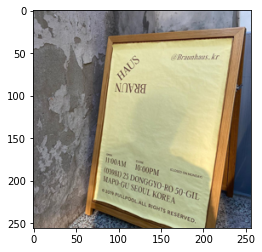

[False, '패션', '연애']


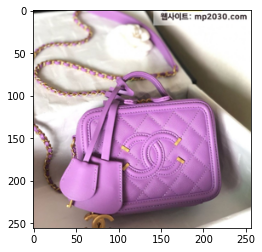

[False, '셀카', '일상']


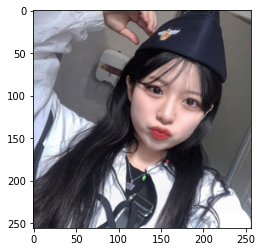

[False, '애완동물', '패션']


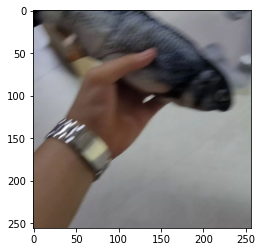

[True, '패션', '패션']


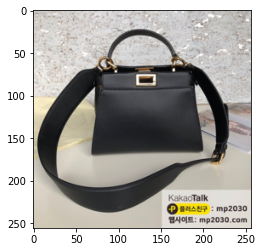

[False, '여행', '애완동물']


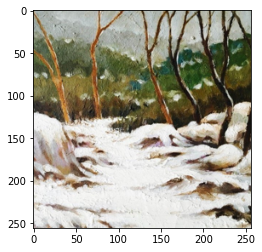

[False, '여행', '패션']


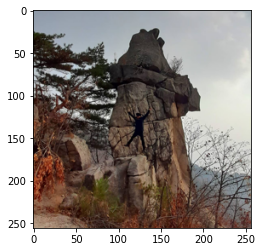

[False, '여행', '연애']


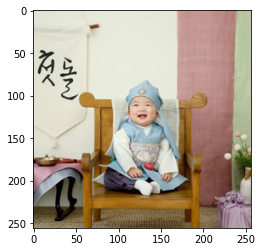

[False, '패션', '셀카']


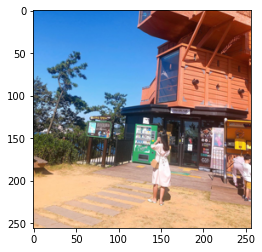

[False, '음식', '여행']


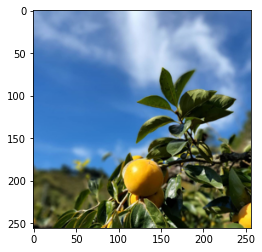

[False, '음식', '여행']


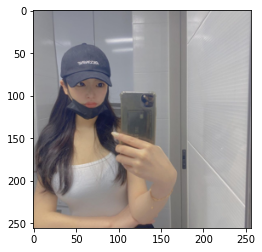

[True, '여행', '여행']


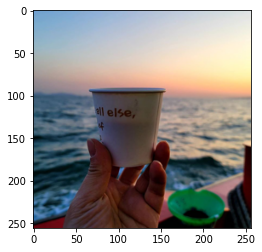

[False, '패션', '셀카']


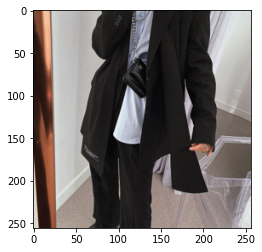

[False, '연애', '여행']


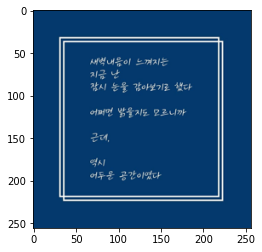

[True, '애완동물', '애완동물']


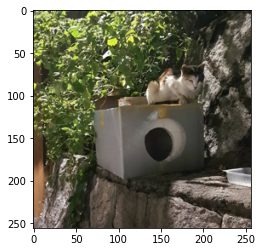

[False, '일상', '셀카']


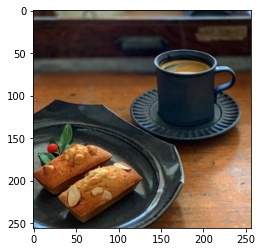

[True, '음식', '음식']


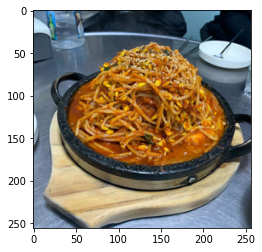

[True, '연애', '연애']


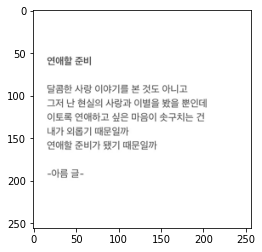

[False, '패션', '일상']


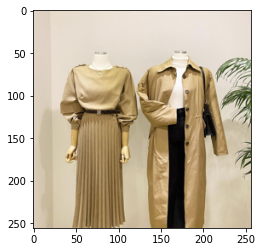

[False, '여행', '셀카']


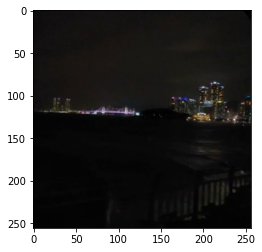

[False, '연애', '패션']


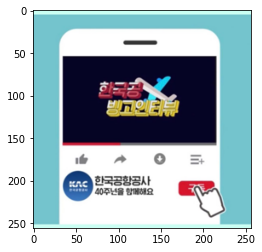

[True, '음식', '음식']


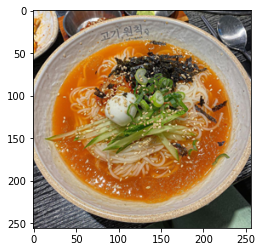

[True, '애완동물', '애완동물']


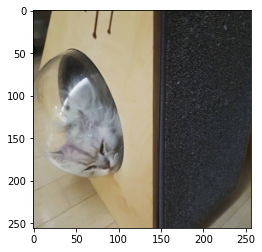

[True, '애완동물', '애완동물']


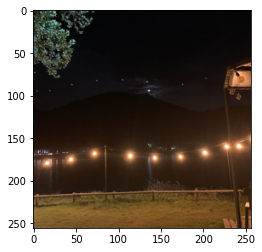

[False, '셀카', '여행']


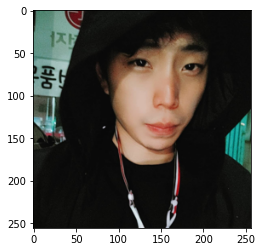

[True, '셀카', '셀카']


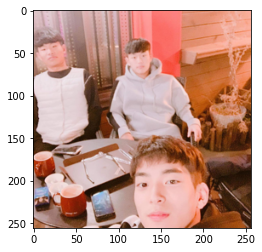

[True, '패션', '패션']


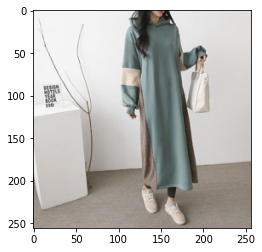

[False, '여행', '패션']


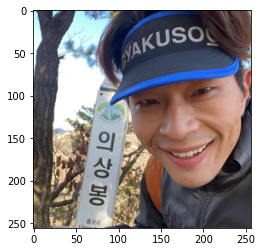

[False, '애완동물', '패션']


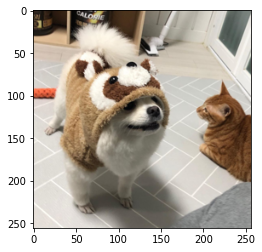

[False, '연애', '음식']


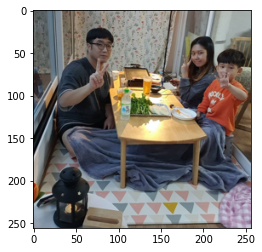

[True, '여행', '여행']


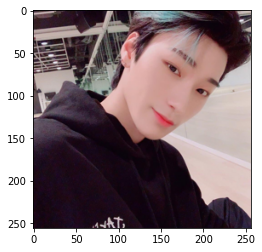

[False, '애완동물', '셀카']


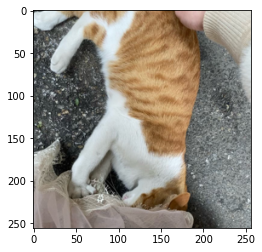

[False, '여행', '애완동물']


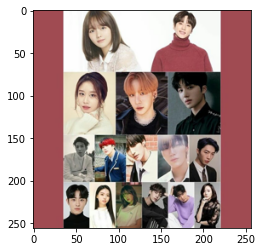

[False, '셀카', '연애']


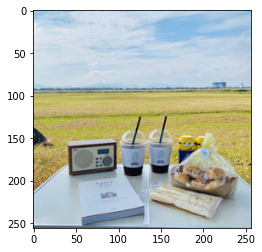

[True, '패션', '패션']


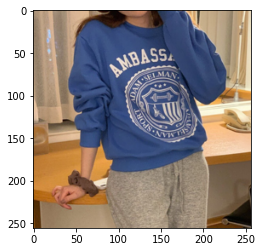

[True, '일상', '일상']


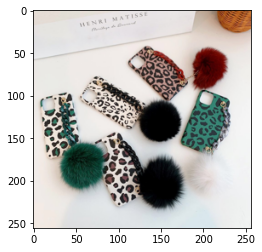

[True, '음식', '음식']


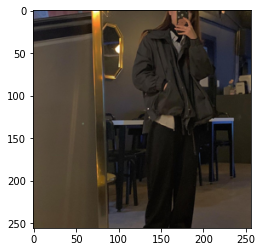

[False, '패션', '애완동물']


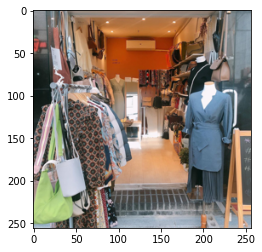

[True, '연애', '연애']


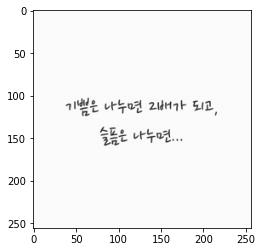

[True, '연애', '연애']


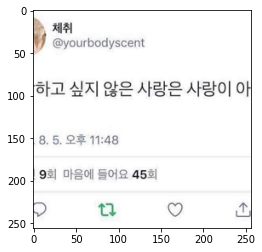

[True, '여행', '여행']


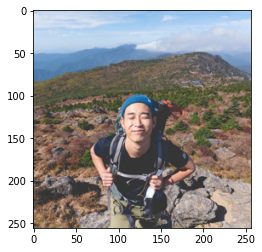

[True, '일상', '일상']


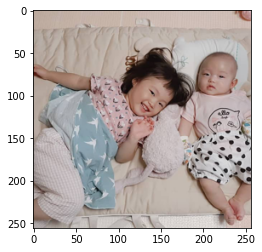

[False, '애완동물', '음식']


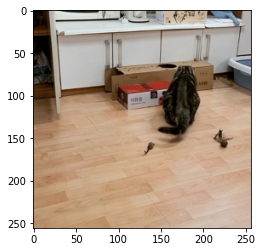

[True, '일상', '일상']


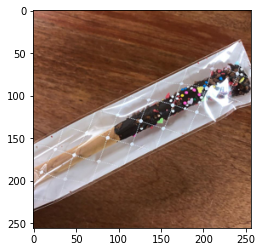

[False, '연애', '음식']


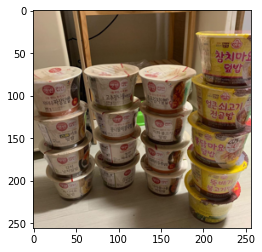

[False, '음식', '패션']


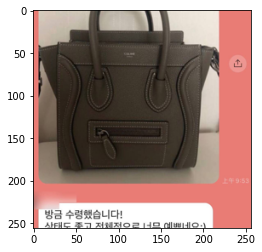

[True, '음식', '음식']


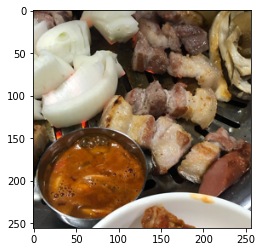

[True, '여행', '여행']


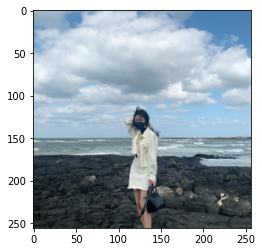

[True, '패션', '패션']


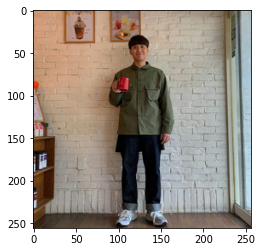

[True, '연애', '연애']


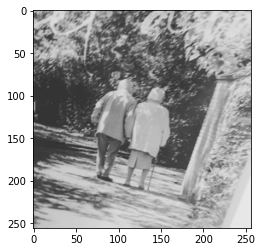

In [50]:
start_idx, end_idx = 50, 100

results = sess.run(outputs2, feed_dict={inputs:image_data[start_idx:end_idx]})
print('정답 예측')

for l, p, img in zip(y_train[start_idx:end_idx], l_label[np.argmax(results, axis=1)], image_data[start_idx:end_idx]):
    print([l==p, l, p])
    plt.imshow(img)
    plt.show()

In [52]:
start_idx, end_idx = 0, 50

results = sess.run(outputs2, feed_dict={inputs:image_valid[start_idx:end_idx]})
print('정답 예측')
[[l==p, l, p] for l, p in zip(y_train[start_idx:end_idx], l_label[np.argmax(results, axis=1)])]

정답 예측


[[False, '애완동물', '여행'],
 [False, '일상', '여행'],
 [False, '애완동물', '여행'],
 [False, '셀카', '패션'],
 [False, '여행', '셀카'],
 [False, '여행', '연애'],
 [False, '애완동물', '음식'],
 [False, '음식', '여행'],
 [False, '패션', '여행'],
 [True, '애완동물', '애완동물'],
 [False, '일상', '애완동물'],
 [False, '여행', '애완동물'],
 [False, '패션', '연애'],
 [True, '패션', '패션'],
 [False, '음식', '여행'],
 [False, '여행', '음식'],
 [False, '음식', '여행'],
 [False, '패션', '애완동물'],
 [False, '음식', '셀카'],
 [False, '애완동물', '연애'],
 [False, '일상', '음식'],
 [True, '여행', '여행'],
 [False, '음식', '패션'],
 [False, '연애', '셀카'],
 [False, '셀카', '음식'],
 [False, '음식', '패션'],
 [False, '애완동물', '연애'],
 [False, '패션', '일상'],
 [False, '셀카', '애완동물'],
 [False, '일상', '패션'],
 [False, '음식', '여행'],
 [True, '패션', '패션'],
 [False, '패션', '일상'],
 [False, '일상', '연애'],
 [True, '연애', '연애'],
 [False, '애완동물', '패션'],
 [False, '일상', '연애'],
 [False, '애완동물', '패션'],
 [False, '애완동물', '패션'],
 [False, '연애', '여행'],
 [False, '셀카', '여행'],
 [True, '음식', '음식'],
 [False, '여행', '애완동물'],
 [True, '애완동물', '애완동물'],
 [Fal